In [59]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [60]:
os.listdir('../dataset')

['eng_dataset.csv', 'README.MD']

### Data Exploratory

In [61]:
DATASET_PATH = "../dataset/eng_dataset.csv"
try:
  dataset = pd.read_csv(DATASET_PATH)
except FileNotFoundError:
  print(f'There is not file with the path {DATASET_PATH}')

In [62]:
dataset.head()

,ID,sentiment,content
0,10941,anger,At the point today where if someone says somet...
1,10942,anger,@CorningFootball IT'S GAME DAY!!!! T MIN...
2,10943,anger,This game has pissed me off more than any othe...
3,10944,anger,@spamvicious I've just found out it's Candice ...
4,10945,anger,@moocowward @mrsajhargreaves @Melly77 @GaryBar...


In [63]:
categories = ['anger', 'fear', 'sadness', 'joy']

In [64]:
dataset.isnull().sum()

ID           0
sentiment    0
content      0
dtype: int64

In [65]:
dataset.duplicated().sum()

0

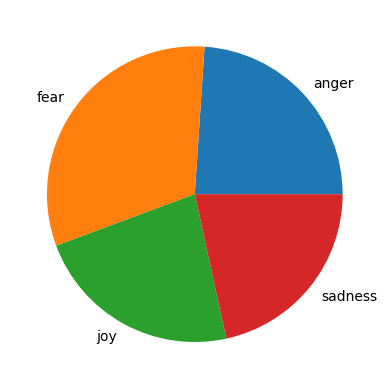

In [66]:
total = dataset.groupby(['sentiment']).size()

total.plot(kind='pie')

plt.show()

In [67]:
dataset['content_length'] = dataset['content'].str.len()

dataset.head(10)

,ID,sentiment,content,content_length
0,10941,anger,At the point today where if someone says somet...,109
1,10942,anger,@CorningFootball IT'S GAME DAY!!!! T MIN...,67
2,10943,anger,This game has pissed me off more than any othe...,115
3,10944,anger,@spamvicious I've just found out it's Candice ...,101
4,10945,anger,@moocowward @mrsajhargreaves @Melly77 @GaryBar...,135
5,10946,anger,@moocowward @mrsajhargreaves @Melly77 @GaryBar...,142
6,10947,anger,wanna go home and focus up on this game . Don'...,65
7,10948,anger,@virginmedia I've been disconnected whilst on ...,117
8,10949,anger,@virginmedia I've been disconnected whilst on ...,109
9,10950,anger,I wanna see you smile I don't wanna see you ma...,56


In [68]:
def get_word_length(text):
  words = text.split()
  return len(words)

print(f'Word Length Example: {get_word_length(dataset['content'][0])}')

Word Length Example: 21


In [69]:
dataset['total_words'] = dataset['content'].apply(get_word_length)

dataset.head(10)

,ID,sentiment,content,content_length,total_words
0,10941,anger,At the point today where if someone says somet...,109,21
1,10942,anger,@CorningFootball IT'S GAME DAY!!!! T MIN...,67,8
2,10943,anger,This game has pissed me off more than any othe...,115,23
3,10944,anger,@spamvicious I've just found out it's Candice ...,101,19
4,10945,anger,@moocowward @mrsajhargreaves @Melly77 @GaryBar...,135,21
5,10946,anger,@moocowward @mrsajhargreaves @Melly77 @GaryBar...,142,22
6,10947,anger,wanna go home and focus up on this game . Don'...,65,15
7,10948,anger,@virginmedia I've been disconnected whilst on ...,117,19
8,10949,anger,@virginmedia I've been disconnected whilst on ...,109,18
9,10950,anger,I wanna see you smile I don't wanna see you ma...,56,13


In [70]:
dataset['mean_word_length'] = dataset['content'].map(lambda x: np.mean([len(word) for word in x.split()]))

In [71]:
dataset.head(10)

,ID,sentiment,content,content_length,total_words,mean_word_length
0,10941,anger,At the point today where if someone says somet...,109,21,4.238095
1,10942,anger,@CorningFootball IT'S GAME DAY!!!! T MIN...,67,8,6.625000
2,10943,anger,This game has pissed me off more than any othe...,115,23,4.043478
3,10944,anger,@spamvicious I've just found out it's Candice ...,101,19,4.368421
4,10945,anger,@moocowward @mrsajhargreaves @Melly77 @GaryBar...,135,21,5.428571
5,10946,anger,@moocowward @mrsajhargreaves @Melly77 @GaryBar...,142,22,5.500000
6,10947,anger,wanna go home and focus up on this game . Don'...,65,15,3.400000
7,10948,anger,@virginmedia I've been disconnected whilst on ...,117,19,5.210526
8,10949,anger,@virginmedia I've been disconnected whilst on ...,109,18,5.055556
9,10950,anger,I wanna see you smile I don't wanna see you ma...,56,13,3.384615


In [72]:
stop_words = stopwords.words("english")
stop_words.append("amp")

def tokenize(text):
  words = word_tokenize(text)
  return words

def remove_stopwords(words) -> [str]:
  words = [word for word in words if word not in stop_words and word.isalpha()]
  return words

def process_text(text) -> str:
  words = tokenize(text)
  words = remove_stopwords(words)

  return ' '.join(words)

In [73]:
dataset['content'] = dataset['content'].apply(process_text)
dataset.head(10)

,ID,sentiment,content,content_length,total_words,mean_word_length
0,10941,anger,At point today someone says something remotely...,109,21,4.238095
1,10942,anger,CorningFootball IT GAME DAY T MINUS relentless,67,8,6.625000
2,10943,anger,This game pissed game year My blood boiling Ti...,115,23,4.043478
3,10944,anger,spamvicious I found Candice Candace She pout l...,101,19,4.368421
4,10945,anger,moocowward mrsajhargreaves GaryBarlow ca come ...,135,21,5.428571
5,10946,anger,moocowward mrsajhargreaves GaryBarlow ca come ...,142,22,5.500000
6,10947,anger,wan na go home focus game Do wan na rage,65,15,3.400000
7,10948,anger,virginmedia I disconnected whilst holiday I mo...,117,19,5.210526
8,10949,anger,virginmedia I disconnected whilst holiday I mo...,109,18,5.055556
9,10950,anger,I wan na see smile I wan na see make frown,56,13,3.384615


In [74]:
words = " ".join(dataset['content'])

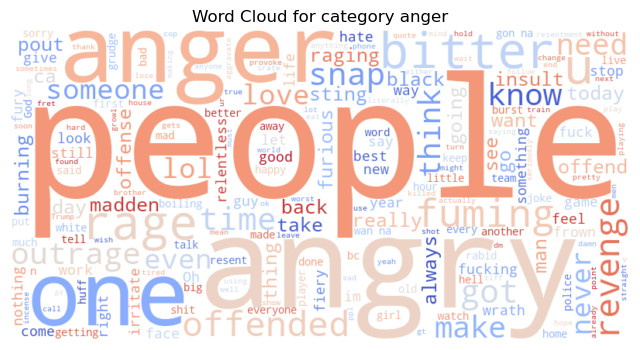

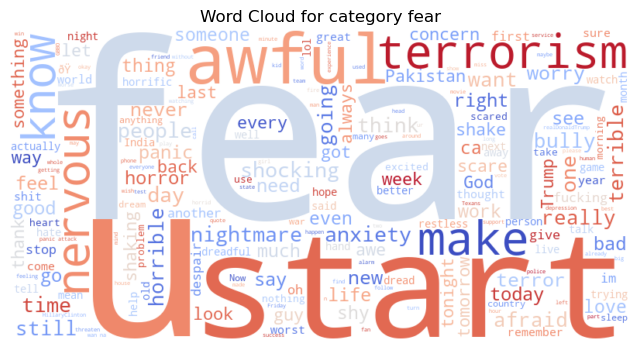

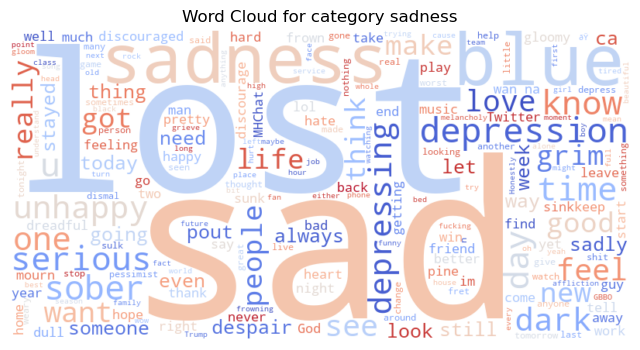

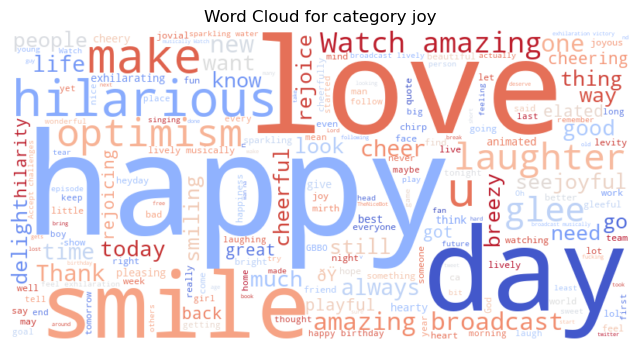

In [75]:
for category in categories:
  words = " ".join(dataset['content'][dataset['sentiment'] == category])

  wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='coolwarm').generate(words)

  plt.figure(figsize=(8, 8))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')  # Hide axes
  plt.title(f'Word Cloud for category {category}')
  plt.show()